In [1]:
from configurations.file_path import FilePathConfig
from configurations.input_column import InputColumnConfig
from configurations.forecast_column import ForecastColumnConfig


from preprocessing.nixtla_preprocessor import NixtlaPreprocessor


file_config = FilePathConfig(
    train_data_features='data/train_data_features.feather',
    val_data_features='data/val_data_features.feather',
    train_data_target='data/train_data_target.feather',
    val_data_target='data/val_data_target.feather'
)


exog_vars = [
    # static
    "companyID", "storeID", "productID",
    # historic
    "missing_value", "not_for_sale", 
    # demand‐distribution stats
    "mean_demand", "std_demand", "kurtosis_demand", "skewness_demand",
    "percentile_10_demand", "percentile_30_demand", "median_demand",
    "percentile_70_demand", "percentile_90_demand", "inter_quartile_range",
    # learned embeddings
    "feature_0000", "feature_0001", "feature_0002",
    "feature_0003", "feature_0004", "feature_0005", "feature_0006"
]


input_column_config = InputColumnConfig(
    date="dateID",
    dp_index="bdID",
    sku_index="skuID",
    target="target",
    exogenous=exog_vars
)
forecast_column_config = ForecastColumnConfig(
    date="dateID",
    sku_index="skuID",
    target="demand",
    exogenous=exog_vars, 
    static=['companyID', 'storeID', 'productID']
)



preprocessor = NixtlaPreprocessor(file_config, input_column_config, forecast_column_config)
preprocessor.load_data()
preprocessor.merge()
preprocessor.remove_skus([2254, 2255, 2256])
df_nixtla = preprocessor.prepare_nixtla()
df_nixtla

,skuID,dateID,demand,companyID,storeID,productID,missing_value,not_for_sale,mean_demand,std_demand,...,percentile_70_demand,percentile_90_demand,inter_quartile_range,feature_0000,feature_0001,feature_0002,feature_0003,feature_0004,feature_0005,feature_0006
0,2245,2016-01-02,0.635300,11.0,1125.0,11.0,0.0,0.0,0.015998,0.996677,...,-0.174943,1.863074,0.437969,0.0,1.0,2.058601,-0.981193,-1.318386,-0.464409,0.0
1,2245,2016-01-03,2.708354,11.0,1125.0,11.0,0.0,0.0,0.015998,0.996677,...,-0.174943,1.863074,0.437969,0.0,1.0,0.435688,-0.914979,-1.101797,-0.449397,0.0
2,2245,2016-01-04,-0.255237,11.0,1125.0,11.0,0.0,0.0,0.015998,0.996677,...,-0.174943,1.863074,0.437969,0.0,1.0,1.226338,-0.835523,-0.863549,-0.629544,0.0
3,2245,2016-01-05,-0.094648,11.0,1125.0,11.0,0.0,0.0,0.015998,0.996677,...,-0.174943,1.863074,0.437969,0.0,1.0,0.310849,-0.848766,-0.993503,-0.689593,0.0
4,2245,2016-01-06,1.197361,11.0,1125.0,11.0,0.0,0.0,0.015998,0.996677,...,-0.174943,1.863074,0.437969,1.0,1.0,-0.396575,-0.716338,-0.852720,-0.449397,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121258,2349,2019-04-26,-1.369510,11.0,1159.0,13.0,0.0,0.0,0.072185,0.871734,...,0.415204,1.064191,1.081645,0.0,1.0,0.564565,-0.084720,-0.409216,0.125591,0.0
121259,2349,2019-04-27,-0.341947,11.0,1159.0,13.0,0.0,0.0,0.072185,0.871734,...,0.415204,1.064191,1.081645,0.0,1.0,0.818630,-0.111690,-0.096463,0.095122,0.0
121260,2349,2019-04-28,0.793780,11.0,1159.0,13.0,0.0,0.0,0.072185,0.871734,...,0.415204,1.064191,1.081645,0.0,0.0,-0.261148,-0.286992,-0.163481,-0.453324,0.0
121261,2349,2019-04-29,-0.017454,11.0,1159.0,13.0,0.0,0.0,0.072185,0.871734,...,0.415204,1.064191,1.081645,0.0,0.0,1.453794,-0.286992,-0.174651,-0.620905,0.0


In [2]:
from forecasting.training import ForecastTrainer
from configurations.forecasting import ForecastConfig
from configurations.enums import ModelName


# Make sure that info logs from logging are shown
import logging
logging.basicConfig(level=logging.INFO) 

forecast_config = ForecastConfig(
    names=[ModelName.ETS, ModelName.LGBM],
    freq="D",
    season_length=7,
    horizon=14,
    lags=[1, 7],
    date_features=["dayofweek", "month"],
)


trainer = ForecastTrainer(
    forecast_config=forecast_config,
    forecast_columns=forecast_column_config,
)

cv_df = trainer.cross_validate(
    df=df_nixtla, 
    n_windows=1,
    step_size=1,
)

INFO:root:Cross-validating with STATS...
INFO:root:Cross-validating with ML...


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 569
[LightGBM] [Info] Number of data points in the train set: 119121, number of used features: 6
[LightGBM] [Info] Start training from score 0.078558


In [3]:
cv_df

,skuID,dateID,cutoff,demand,ets,LGBMRegressor,RandomForestRegressor
0,2245,2019-04-17,2019-04-16,-0.722404,-0.608609,-0.549668,-0.528601
1,2245,2019-04-18,2019-04-16,-0.459622,-0.615600,-0.536846,-0.501747
2,2245,2019-04-19,2019-04-16,-0.459622,-0.621521,-0.386887,-0.277944
3,2245,2019-04-20,2019-04-16,-0.211440,-0.290952,-0.179814,-0.107061
4,2245,2019-04-21,2019-04-16,3.547795,1.959001,1.755571,1.588128
...,...,...,...,...,...,...,...
1423,2349,2019-04-26,2019-04-16,-1.369510,-0.516908,-0.046613,-0.098939
1424,2349,2019-04-27,2019-04-16,-0.341947,-0.558233,0.056813,0.242015
1425,2349,2019-04-28,2019-04-16,0.793780,0.149162,0.615412,0.567374
1426,2349,2019-04-29,2019-04-16,-0.017454,-0.563171,-0.292834,0.090045


In [5]:
from configurations.metrics import MetricConfig
from forecasting.evaluation import Evaluator
from configurations.enums import MetricName

metric_config = MetricConfig(
    names=[MetricName.MASE, MetricName.MSSE],
    seasonality=7,
)

evaluator = Evaluator(
    metric_config,
    forecast_column_config
    )

evaluations = evaluator.evaluate(cv_df, train_df=df_nixtla)




In [6]:
evaluations

,skuID,metric,ets,LGBMRegressor,RandomForestRegressor
0,2245,mase,1.038954,1.229277,1.567748
1,2246,mase,1.189018,1.015831,1.186359
2,2247,mase,1.029789,1.062793,1.162366
3,2248,mase,1.088611,1.105934,1.271562
4,2249,mase,1.248725,1.291497,1.285539
...,...,...,...,...,...
199,2345,msse,1.864059,1.684364,2.037852
200,2346,msse,0.624754,0.695794,0.725177
201,2347,msse,0.529671,0.840171,0.968408
202,2348,msse,0.430369,0.425880,0.376128


In [ ]:
#evaluations[[col for col in evaluations if col not in [evaluations.skuID, 'metric']].mean()
base_cols = [col for col in evaluations.columns if col not in ['skuID', 'metric']]
mean_evaluations = evaluations.groupby('metric')[base_cols].mean()
mean_evaluations.to_dict()

{'skuID': {'mase': 2298.235294117647, 'msse': 2298.235294117647},
 'ets': {'mase': 0.8679793591338966, 'msse': 0.7988539236482571},
 'LGBMRegressor': {'mase': 0.9127339488737367, 'msse': 0.7899421427377101},
 'RandomForestRegressor': {'mase': 0.9352263939335203,
  'msse': 0.8443638968148586}}

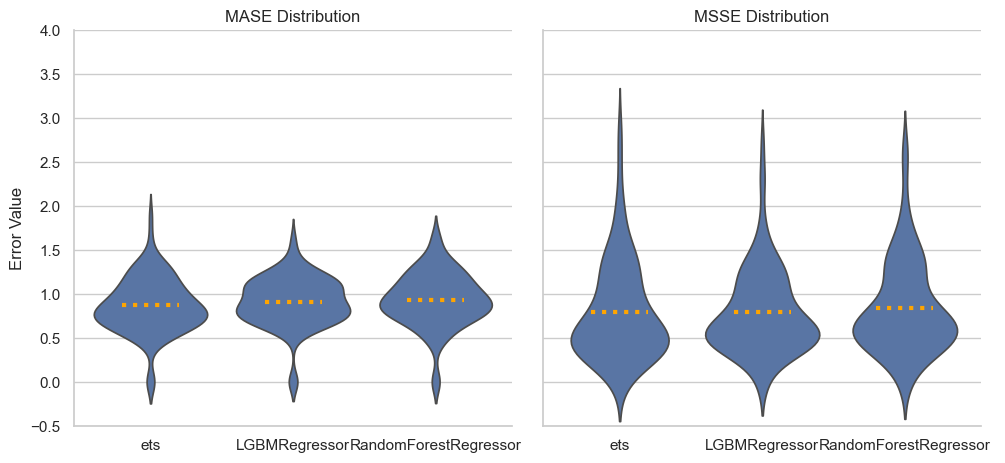

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Identify your model columns
models = [c for c in evaluations.columns if c not in ['skuID', 'metric']]

# 2) Melt to long form
long = evaluations.melt(
    id_vars=['skuID', 'metric'],
    value_vars=models,
    var_name='model',
    value_name='error'
)

# 3) Upper‐case the metric labels
long['metric'] = long['metric'].str.upper()

# 4) Filter to MASE and MSSE
long = long[long['metric'].isin(['MASE', 'MSSE'])]

# 5) Draw the violin facets
sns.set(style="whitegrid")
g = sns.catplot(
    data=long,
    x="model", y="error", col="metric",
    kind="violin",
    inner=None,     # turn off the default inner markings
    sharey=True,
    height=5, aspect=1, 
    
)

g.set(ylim=(-0.5, 4))

# 6) Overlay wide mean‐lines
for ax, metric in zip(g.axes.flatten(), ['MASE', 'MSSE']):
    # compute mean per model for this metric
    means = long[long['metric'] == metric].groupby('model')['error'].mean()
    for idx, model in enumerate(models):
        m = means.loc[model]
        # draw a horizontal line spanning the violin roughly (±0.3)
        ax.hlines(y=m, xmin=idx - 0.2, xmax=idx + 0.2, linewidth=3, colors='orange', linestyles='dotted')

# 7) Labels & titles
g.set_axis_labels("", "Error Value")
g.set_titles("{col_name} Distribution")
plt.show()
